#Calibration and evaluation of DNN model

Created on Aug 09 09:29:22 2022
@author: Javier Muro

This code trains a feed forward neural network (modelDNN.py and gkfold_DNN.py) to predict either biomass or species richness.

be_preprocessing.py moduls preprocess the data frame

We can also use a a random forest (gkfold_RF.py) instead of the nn for comparison purposes.
 
Training and validation points are distributed grouping the replicates to avoid spatial and temporal dependencies. 

Alternatively, the user can perform a spatial cross-validation, selecting
two regions for training and the remaining region for validation.

Machine learning terminology found across tutorials and courses: 

1.   Validation dataset: part of the training dataset used by model to fine tune itself and by you to fine tune predictors and hyper parameters (e.g. epochs, activation function, number of layers...). Set in validation_split when applying the .fit function.

2.   Test dataset: datset never seen by model. Used to evaluate final model's accuracy once hyperparameters and predictors have been determined.

3.   Labels: 'y', study variable, dependent or response variable

4.   Features: 'x', predictors

Dataframe contains grassland vegetation information collected over three regions in Germany. Each region has 50 plots, and each plot is sampled in May for 4 years: 2017-2020

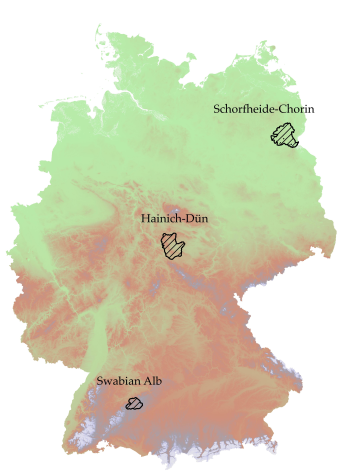

Predictors are the interpolated spectral data from the 10 bands of Sentinel-2 at 16 time stamps: from April to October, every 14 days.

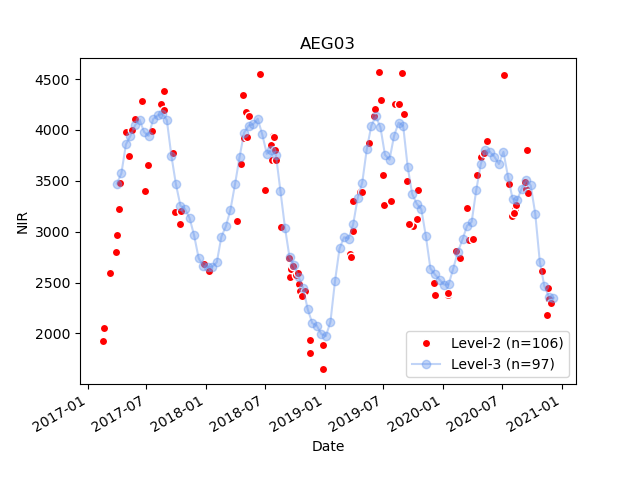

## Import libraries and data

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import statistics
import math

from keras.utils.vis_utils import plot_model

from google.colab import drive, files

Mount google drive to access dataset

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Change working directory to folder storing modules. If you copied my drive folder, the datasets will be stored in /drive/My Drive



In [3]:
%cd .'/drive/MyDrive/SEBAS/Pyproject_modules/SeBAS_project/'

/content/drive/MyDrive/SEBAS/Pyproject_modules/SeBAS_project


In [4]:
Mydataset_0 = pd.read_csv('data/Bexis_Sentinels_full_dataset.csv') 

## Explore and prepare the data

Visualize response variables and predictors.

In [5]:
print(list(Mydataset_0.columns))

['Year', 'ep', 'yep', 'explo', 'x', 'y', 'number_vascular_plants', 'SpecRichness', 'height_cm', 'biomass_g', 'NMDS1', 'NMDS2', 'SpecRich_157', 'Shannon_157', 'Simpson_157', 'inverse_Simpson_157', 'PielouEvenness_157', 'Rao_Q_157', 'Redundancy_157', 'Shannon', 'Simpson', 'FisherAlpha', 'PielouEvenness', 'LUI_2015_2018', 'SoilTypeFusion', 'slope', 'aspect', 'LAI', 'blue', 'green', 'red', 'nir', 'nirb', 're1', 're2', 're3', 'swir1', 'swir2', 'EVI', 'SAVI', 'GNDVI', 'ARVI', 'CHLRE', 'MCARI', 'NDII', 'MIRNIR', 'MNDVI', 'NDVI', 'VHMean_May', 'VVMean_May', 'VVVH', 'TWI', 'blue_0', 'green_0', 'red_0', 'nir_0', 'nirb_0', 're1_0', 're2_0', 're3_0', 'swir1_0', 'swir2_0', 'blue_1', 'green_1', 'red_1', 'nir_1', 'nirb_1', 're1_1', 're2_1', 're3_1', 'swir1_1', 'swir2_1', 'blue_2', 'green_2', 'red_2', 'nir_2', 'nirb_2', 're1_2', 're2_2', 're3_2', 'swir1_2', 'swir2_2', 'blue_3', 'green_3', 'red_3', 'nir_3', 'nirb_3', 're1_3', 're2_3', 're3_3', 'swir1_3', 'swir2_3', 'blue_4', 'green_4', 'red_4', 'nir_4'

In [6]:
Mydataset_0.head(5)

,Year,ep,yep,explo,x,y,number_vascular_plants,SpecRichness,height_cm,biomass_g,...,red_15,nir_15,nirb_15,re1_15,re2_15,re3_15,swir1_15,swir2_15,S2Q,S2QF
0,2017,AEG01,012017ALB,ALB,525313,5360594,14.0,33.0,13.38,153.25,...,418.0,4564.0,4418.0,1368.0,3778.0,4277.0,2138.0,955.0,0.680651,0.656078
1,2017,AEG02,022017ALB,ALB,535010,5358415,12.0,21.0,18.75,164.75,...,404.0,3988.0,3931.0,1152.0,3123.0,3695.0,1968.0,915.0,0.976994,0.359795
2,2017,AEG03,032017ALB,ALB,539398,5370311,18.0,35.0,4.53,66.60,...,506.0,3242.0,3053.0,1157.0,2526.0,2891.0,2050.0,1009.0,0.677909,0.485461
3,2017,AEG04,042017ALB,ALB,531016,5359610,14.0,22.0,19.75,189.50,...,443.0,4101.0,3999.0,1239.0,3231.0,3760.0,2238.0,1077.0,0.700765,0.802787
4,2017,AEG05,052017ALB,ALB,532511,5359895,17.0,20.0,15.25,195.25,...,324.0,4997.0,4810.0,1166.0,3875.0,4636.0,2086.0,908.0,0.724976,0.789717


Plot a couple of variables against each other

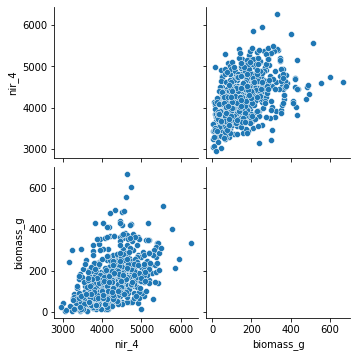

In [7]:
sns.pairplot(Mydataset_0[['nir_4','biomass_g']], diag_kind="biomass_g")

Select the study variable ('biomass_g' or 'SpecRichness') and run the preprocesing module. We can change the predictors used within this module. It returns two dataframes, one to analyze, and another one with relevant environmental information to color the predictions vs labels plots later on.

In [5]:
studyvar = 'SpecRichness'
import be_preprocessing

Create datasets needed in the global environment. MydatasetLUI is contains information on land use intensity, in case we want to plot predicted vs in situ, color coded by land use

In [6]:
Mydataset = be_preprocessing.be_preproc(studyvar)[0]

MydatasetLUI = be_preprocessing.be_preproc(studyvar)[1]
print(Mydataset.head())
print(list(Mydataset.columns))

      ep  SpecRichness  blue_0  green_0  red_0   nir_0  nirb_0   re1_0  \
0  AEG01          33.0   484.0    818.0  659.0  3581.0  3618.0  1310.0   
1  HEG01          19.0   356.0    693.0  406.0  4236.0  4051.0  1074.0   
2  SEG01          16.0   319.0    649.0  365.0  3968.0  3851.0  1043.0   
3  AEG01          29.0   470.0    795.0  726.0  3950.0  3705.0  1311.0   
4  HEG01          22.0   380.0    691.0  477.0  3491.0  3348.0  1093.0   

    re2_0   re3_0  ...  blue_15  green_15  red_15  nir_15  nirb_15  re1_15  \
0  2933.0  3374.0  ...    366.0     845.0   418.0  4564.0   4418.0  1368.0   
1  3284.0  3962.0  ...    383.0     648.0   401.0  2854.0   2837.0   935.0   
2  3034.0  3640.0  ...    381.0     780.0   430.0  4816.0   4563.0  1222.0   
3  2979.0  3463.0  ...    411.0     683.0   609.0  2914.0   2722.0  1179.0   
4  2726.0  3185.0  ...    516.0     766.0   639.0  2989.0   2854.0  1097.0   

   re2_15  re3_15  swir1_15  swir2_15  
0  3778.0  4277.0    2138.0     955.0  
1  230

#Run the DNN model

The data contain replicates (4 observations per plot, one per year during 4 years). Thus, we have to ensure that all replicates are always in the same fold. For that, gkfold_DNN.py groups the observations by plot. The gkfold_DNN.py module uses the modelDNN.py module, which contains the architecture of the DNN. It uses also plot_loss.py that displays the loss function across epochs. We build a df with the predictions for the 5 folds and link them to the original dataset

Fold#1
Epoch 367: early stopping
Fold#2
Epoch 406: early stopping
Fold#3
Epoch 250: early stopping
Fold#4
Epoch 327: early stopping
Fold#5
Epoch 330: early stopping


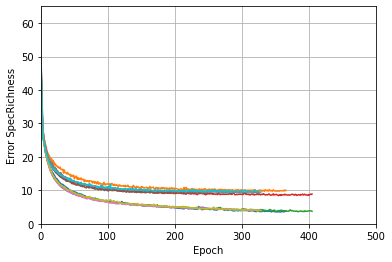

In [7]:
import gkfold_DNN

EPOCHS = 500

gkfold_DNN.gkfold_DNN(EPOCHS, studyvar)

# build a df of the accumulated predictions vs labels
pred_trues = gkfold_DNN.pred_trues
pred_truesdf = pd.concat(pred_trues)

# build also a df with the test features in the order in which they were split
testfeatures_order = gkfold_DNN.testfeatures_order2
testfeatures_orderdf = pd.concat(testfeatures_order)

# concatenate both laterally. They should correspond.
rsdf = pd.concat([testfeatures_orderdf, pred_truesdf], axis=1)

# merge it with the original dataset using the features as joining field
# This allows us to display preds vs lables along with other variables
Mypredictions = pd.merge(rsdf, MydatasetLUI)

The plot above shows the accumulated loss and validation_loss functions for the five folds. Have a look at the model structure.

#Plot results

Plot predictions versus labels using a density plot

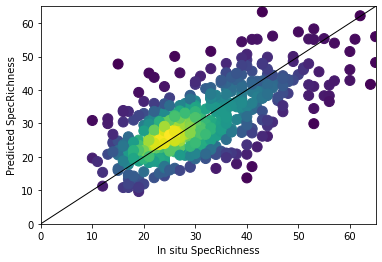

In [8]:
#Make a density plot
from scipy.stats import gaussian_kde

y = Mypredictions['preds']#.astype(float)
x = Mypredictions['labels']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)

#plt.xlabel('Biomass $(g/m^{2})$')
#plt.ylabel('Predicted biomass $(g/m^{2})$')
plt.ylabel(f'Predicted {studyvar}')
plt.xlabel(f'In situ {studyvar}')
plt.xlim(0, max(Mydataset[studyvar]))
plt.ylim(0, max(Mydataset[studyvar]))
#add a r=1 line
line = np.array([0,max(Mydataset[studyvar])])
plt.plot(line,line,lw=1, c="black")
plt.show()

In [ ]:
#fig.savefig('sppRich_2022.png')
#files.download('sppRich_2022.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Plot predictions vs labels colored by some field such as LUI

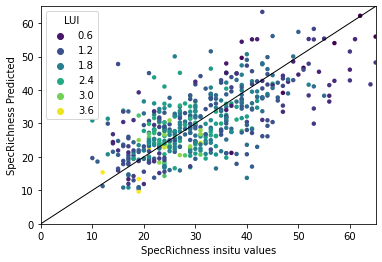

In [9]:
Mypredictions = Mypredictions.rename(columns = {'LUI_2015_2018':'LUI'})

# Plot predictions color coded with LUI
myplot = sns.scatterplot(data=Mypredictions,
                         y='preds',
                         x=studyvar,
                         hue = 'LUI', 
                         palette='viridis',
                         #cmap = 'Reds',
                         linewidth=0,
                         s = 20
                         )
plt.ylabel(f'{studyvar} Predicted')
plt.xlabel(f'{studyvar} insitu values')
myplot.legend(title="LUI")
plt.xlim(0, max(Mydataset[studyvar]))
plt.ylim(0, max(Mydataset[studyvar]))

#add a r=1 line
line = np.array([0,max(Mydataset[studyvar])])
plt.plot(line,line,lw=1, c="black")
plt.show()
#fig.savefig(f'{studyvar}allfolds_plot2.svg')

Another way to plot results using the compiled df of predictions vs labels

Fold#1
Epoch 249: early stopping
Fold#2
Fold#3
Epoch 266: early stopping
Fold#4
Epoch 377: early stopping
Fold#5
Epoch 396: early stopping


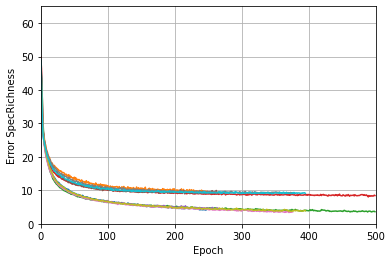

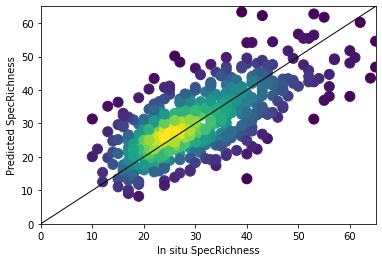

Fold#1
Epoch 219: early stopping
Fold#2
Epoch 435: early stopping


In [ ]:
"""
% Matlab function to calculate model evaluation statistics 
% S. Robeson, November 1993
% Author of matlab function: Zbynek Malenovksy

% zb(1):  mean of observed variable 
% zb(2):  mean of predicted variable 
% zb(3):  std dev of observed variable 
% zb(4):  std dev of predicted variable 
% zb(5):  correlation coefficient
% zb(6):  intercept of OLS regression
% zb(7):  slope of OLS regression
% zb(8):  mean absolute error (MAE)
% zb(9):  index of agreement (based on MAE)
% zb(10): root mean squared error (RMSE)
% zb(11): relative root mean squared error (RMSE)
% zb(12): RMSE, systematic component
% zb(13): RMSE, unsystematic component
% zb(14): index of agreement (based on RMSE)

""" 
# I have to import in each iteration
import gkfold_DNN 
# import kfold_RF
met_ls=[]
for i in range(3):
    
    EPOCHS = 500
    
    # We build a df of the accumulated predictions vs labels
    # for DNN or RF

    gkfold_DNN.gkfold_DNN(EPOCHS, studyvar)
    pred_trues = gkfold_DNN.pred_trues

    #kfold_RF.kfold_RF(studyvar)
    #pred_trues = kfold_RF.pred_trues
    
    pred_truesdf = pd.concat(pred_trues).reset_index(drop=True)
    
    # Select the last batch of predictions.
    # Predictions accumulate when we iterate 10 times
    # even if we delete all the variables
    pred_truesdf = pred_truesdf.tail(Mydataset.shape[0])
    
    # Predictions vs labels
    y = pred_truesdf['preds']
    x = pred_truesdf['labels']
    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=100)
    
    plt.ylabel(f'Predicted {studyvar}')
    plt.xlabel(f'In situ {studyvar}')
    plt.xlim(0, max(Mydataset[studyvar]))
    plt.ylim(0, max(Mydataset[studyvar]))
    # add a r=1 line
    line = np.array([0,max(Mydataset[studyvar])])
    plt.plot(line,line,lw=1, c="black")
    plt.show()
    
    # Calculate additional metrics
    n = len(x)
    so = x.sum()
    sp = y.sum()
    
    sumo2 = (x**2).sum()
    sump2 = (y**2).sum()
    
    sum2 = ((x-y)**2).sum()
    sumabs = abs(x-y).sum()
    
    sumdif = (x-y).sum()
    cross = (x*y).sum()
    
    obar = x.mean()
    pbar = y.mean()
    
    sdo = math.sqrt(sumo2/n - obar*obar)
    sdp = math.sqrt(sump2/n-pbar*pbar)
    c = cross/n - obar*pbar
    r = c/(sdo*sdp)
    r2 = r**2
    b = r*sdp/sdo
    a = pbar - b*obar
    mse = sum2/n
    mae = sumabs/n
    
    msea = a**2
    msei = 2*a*(b-1)*obar
    msep = ((b-1)**2) *sumo2/n
    mses = msea + msei + msep
    mseu = mse - mses
    
    rmse = math.sqrt(mse)
    rrmse = rmse/obar
    rmses = math.sqrt(mses)
    rmseu = math.sqrt(mseu)
        
    pe1 = (abs(y-obar) + abs(x-obar)).sum()
    pe2 = ((abs(y-obar) + abs(x-obar))**2).sum()
    d1 = 1 - n*mae/pe1;
    d2 = 1 - n*mse/pe2;
    
    zb = [obar,pbar,sdo,sdp,r,a,b,mae,d1,rmse,rrmse,rmses,rmseu,d2]
    
    results = [r2, rrmse, rmses, rmseu]
    
    met_ls.append(results)

In [24]:
# Check that length = number of loops    
len(met_ls)

3

In [25]:
# Extract specific metrics and calculate mean and sd
r2_hat = statistics.mean([x[0] for x in met_ls])
r2_sd = statistics.pstdev([x[0] for x in met_ls])

rrmse_hat = statistics.mean([x[1] for x in met_ls])
rrmse_sd = statistics.pstdev([x[1] for x in met_ls])

rmses_hat = statistics.mean([x[2] for x in met_ls])
rmses_sd = statistics.pstdev([x[2] for x in met_ls])

rmseu_hat = statistics.mean([x[3] for x in met_ls])
rmseu_sd = statistics.pstdev([x[3] for x in met_ls])

Print the accuracy metric statistics of the 5 folds

In [26]:
print('r2_hat: ' '%.2f'% r2_hat)
print('r2_sd: ''%.2f'% r2_sd)

print('rrmse_hat: ' '%.2f'% rrmse_hat)
print('rrmse_sd: ' '%.2f'% rrmse_sd)

print(f'rmses_hat: ' '%.2f'% rmses_hat)
print(f'rmses_sd: ' '%.2f'%rmses_sd)

print(f'rmseu_hat: ' '%.2f'% rmseu_hat)
print(f'rmseu_sd: ' '%.2f'%rmseu_sd)

r2_hat: 0.43
r2_sd: 0.01
rrmse_hat: 0.48
rrmse_sd: 0.00
rmses_hat: 56.34
rmses_sd: 0.74
rmseu_hat: 50.68
rmseu_sd: 0.34


#Random forest option

Rinse and repeat for Random Forest. Reset the runtime, because the rsq_list values from previous runs remain stored and do not dissapear even if emptying the list manually with `rsq_list=[]`.  

In [28]:
# 2.- kfold approach with RF
import gkfold_RF
gkfold_RF.gkfold_RF(studyvar)

# build a df of the accumulated predictions vs labels
pred_trues = gkfold_RF.pred_trues
pred_truesdf = pd.concat(pred_trues)

# build also a df with the test features in the order in which they were split
testfeatures_order = gkfold_RF.testfeatures_order2
testfeatures_orderdf = pd.concat(testfeatures_order)

# concatenate both laterally. They should correspond.
rsdf = pd.concat([testfeatures_orderdf, pred_truesdf], axis=1)

# merge it with the original dataset using the features as joining field
# This allows us to display preds vs lables along with other variables
Mypredictions = pd.merge(rsdf, MydatasetLUI)

importance_list = gkfold_RF.importance_list

Fold#1
Fold#2
Fold#3
Fold#4
Fold#5


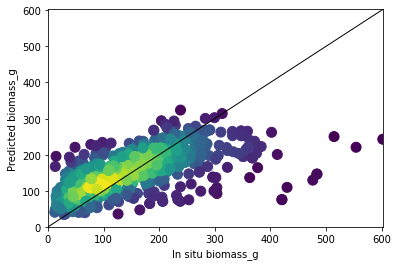

In [29]:
#Make a density plot
y = Mypredictions['preds']#.astype(float)
x = Mypredictions['labels']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)

#plt.xlabel('Biomass $(g/m^{2})$')
#plt.ylabel('Predicted biomass $(g/m^{2})$')
plt.ylabel(f'Predicted {studyvar}')
plt.xlabel(f'In situ {studyvar}')
plt.xlim(0, max(Mydataset[studyvar]))
plt.ylim(0, max(Mydataset[studyvar]))
#add a r=1 line
line = np.array([0,max(Mydataset[studyvar])])
plt.plot(line,line,lw=1, c="black")
plt.show()

# Spatial cross-validation

Or do a spatial cross validation, selecting two regions (explo) for training, and a third one for validation.

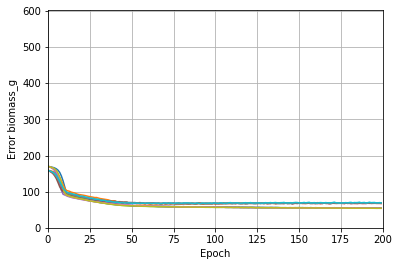

In [30]:
import spcv_DNN

# Choose which site is used for test and which one(s) for training
EPOCHS = 200
Mydataset['explo'] = MydatasetLUI['explo']
Mydataset=Mydataset.drop('ep', axis=1)
train_dataset = Mydataset[(Mydataset['explo']=='SCH')       
                          | (Mydataset['explo'] == 'HAI')   # take this line out to use only 1 site for training
                          ].drop(['explo'], axis=1)
                            
test_dataset = Mydataset[Mydataset['explo']=='ALB'].drop(['explo'], axis=1)

spcv_DNN.spcv_DNN(EPOCHS, train_dataset, test_dataset, studyvar)

# Put results as variables in global environment

RMSE_test_list = spcv_DNN.RMSE_test_list
RRMSE_test_list = spcv_DNN.RRMSE_test_list
rsq_list = spcv_DNN.rsq_list

predictions_list = spcv_DNN.predictions_list

In [35]:
print(rsq_list)
print(RMSE_test_list)
print(RRMSE_test_list)

[0.4407638533454107, 0.45785435115421924, 0.45102480701665704, 0.4414485989861104, 0.4436519028718409]
[62.379330983620584, 61.24431598508869, 61.959981292801345, 62.75660529768834, 62.66722208521514]
[0.4006665564177742, 0.39337628023536836, 0.39797304570026554, 0.40308981421581147, 0.40251569994785624]
